## Diagonalizing symmetric matrix using forward euler
Let $x\in \mathbb R^n$ and $A$ be a symmetric matrix of size $n\times n $. The solution to the ODE
$$     \frac{dx}{dt} = -x(t) + f( x (t))  ,$$
where 
$$     f ( x) =  \left[ x^\intercal  x A + (1- x^\intercal A x)I\right] x $$
is known to converge to an eigenvector of the matrix $A$. Here we use forward euler to solve this equation, and exploit the approach outlined by 	https://www.researchgate.net/publication/222949356_Neural_networks_based_approach_for_computing_eigenvectors_and_eigenvalues_of_symmetric_matrix in order to fully diagonalize the matrix. Results are checked against NumPy's library  function `np.linalg.eigh` . 


In [1]:
import numpy as np
import os, sys
sys.path.append(os.path.join(os.getcwd(), "../"))
import eigenSolverFE as esfe
import Eigenvects
import time
import importlib
import plotter
import matplotlib.pyplot as plt

In [2]:
#load the matrix
A = np.load("A.npy")
#define (pseudo)random initial condition (once we generated it once we leave it fixed)
x0 = np.array([-0.99581536, -0.44185623 , -0.72648535,  0.42184483, -0.4879591 , 0.32223256])

In [3]:
eigvecs=[]
eigvals=[]
starttime = time.time()
for jj in range(A.shape[0]):
    print(f"Looking for {jj}-th eigenvector")
    print(f"Initial condition:\n{x0}")
    t, xsol = esfe.forward_euler_sol(A, x0, Tmax=8, Nsteps=200000)
    #solution at last step should be an eigenvector of A
    curr_eigvec = xsol[:,-1]
    
    #we remove the component along other eigenvectors from the solution at the last step 
    #this is to ensure that eigvecs remains an orthogonal set within numerical precision
    for ii in range(len(eigvecs)):
        curr_eigvec-=Eigenvects.normalized_proj(curr_eigvec, eigvecs[ii])
    
    #compute the corresponding eigenvalue:
    curr_eigval = (curr_eigvec.T @ A @ curr_eigvec)/np.linalg.norm(curr_eigvec)**2
    eigvecs.append(curr_eigvec)
    eigvals.append(curr_eigval)
    x0 = Eigenvects.create_orthogonal(eigvecs)

endtime = time.time()
true_spectrum, true_eigvecs = np.linalg.eigh(A)
eigvals.reverse()
eigvecs.reverse()
print(f"Diagonalized matrix in {endtime-starttime:.3f} seconds")
print(f"Found the following spectrum: {eigvals}\n")
print(f"spectrum using numpy: {true_spectrum}\n\n")
print(f"and the following eigenvectors: {eigvecs}\n")
print(f"eigenvectors using numpy: {true_eigvecs}\n")

Looking for 0-th eigenvector
Initial condition:
[-0.99581536 -0.44185623 -0.72648535  0.42184483 -0.4879591   0.32223256]
Looking for 1-th eigenvector
Initial condition:
[-0.63510751 -0.40121513  0.60725109 -0.02808244 -0.16500768 -0.1972177 ]
Looking for 2-th eigenvector
Initial condition:
[-0.25446738 -0.45675524 -0.0569535  -0.25783141  0.07351823  0.80715261]
Looking for 3-th eigenvector
Initial condition:
[-0.08583852 -0.2462927   0.01103229  0.61256475  0.74229418  0.07492482]
Looking for 4-th eigenvector
Initial condition:
[-0.11813854  0.11412819 -0.78229103 -0.15228835 -0.50011875  0.29618961]
Looking for 5-th eigenvector
Initial condition:
[-0.15764154  0.24058518 -0.11757875 -0.50055898 -0.78335433 -0.1980905 ]
Diagonalized matrix in 30.886 seconds
Found the following spectrum: [-2.306563469253462, -1.5424883431191996, -0.5395527916085724, 0.19045385754244284, 1.685672063045669, 2.202005499960224]

spectrum using numpy: [-2.30656508 -1.54248674 -0.53955334  0.19045441  1.685

### Comparison with numpy's library functions

First we compute the relative error on every eigenvalue as
$$ \epsilon =  \left \lvert \frac{\lambda_{numerical}-\lambda_{numpy}}{\lambda_{numpy}}\right\rvert $$

In [4]:
relative_errors = np.abs((np.array(eigvals)-true_spectrum)/true_spectrum)
print(relative_errors)

[6.98864330e-07 1.04216033e-06 1.01136249e-06 2.88592885e-06
 8.11882934e-08 6.23797407e-08]


To compare a numerical eigenvector $\vert v\rangle $ with an eigenvector $\vert w \rangle$ gotten by numpy.linalg.eigh, we check if the following equality holds:
$$ \frac{\langle v \vert w \rangle ^2}{\langle v \vert v \rangle \langle w\vert w\rangle} = 1 $$
This happens if and only if $\vert v \rangle$ and $\vert w \rangle $ are parallel (see Cauchy-Schwarz inequality as a reference)

In [5]:
def parallel_check(v,w):
    '''should return 1 if v and w are parallel'''
    num = np.dot(v,w)**2
    den = np.dot(v,v)*np.dot(w,w)
    
    return num/den

In [6]:
#this for loop should print values which are very close to zero
#if eigvecs are nicely parallel to the true_eigvecs found by numpy.linalg.eigh
Lcheck = []
for ii in range(6):
    Lcheck.append(1-parallel_check(eigvecs[ii], true_eigvecs[:,ii]))
    print(Lcheck[ii])

2.1096927503849727e-06
2.1141226966836513e-06
7.580503271764627e-07
7.539471889028704e-07
2.6636743033492394e-07
2.660305490342907e-07


In [7]:
#print nice table in tex format
for ii in range(6):
    print(f"{true_spectrum[ii]:.3f}", f"{eigvals[ii]:.3f}", f"{relative_errors[ii]:.2e}",
          f"{Lcheck[ii]:.2e}", sep=" & ", end = " \\\\\n")

-2.307 & -2.307 & 6.99e-07 & 2.11e-06 \\
-1.542 & -1.542 & 1.04e-06 & 2.11e-06 \\
-0.540 & -0.540 & 1.01e-06 & 7.58e-07 \\
0.190 & 0.190 & 2.89e-06 & 7.54e-07 \\
1.686 & 1.686 & 8.12e-08 & 2.66e-07 \\
2.202 & 2.202 & 6.24e-08 & 2.66e-07 \\


### Plot of the FE solution with the first initial condition

In [8]:
x0 = np.array([-0.99581536, -0.44185623 , -0.72648535,  0.42184483, -0.4879591 , 0.32223256])
t, xsol = esfe.forward_euler_sol(A, x0, Tmax=8, Nsteps=200000)

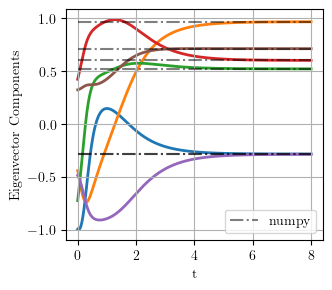

In [9]:
fig = plotter.plot_eigenvector_components_convergence(t, xsol)
ax = fig.axes[0]
x_eig = np.array([0,8])
#want to renormalize the true eigvector to match the norm of the numerical FE estimate
ratio= eigvecs[5][0]/true_eigvecs[0,5]
for jj in range(6):
    #ax.lines[jj]._label = f"{jj+1}"
    ax.plot(x_eig, ratio*true_eigvecs[jj,5]*np.ones(2), color='black', linestyle='-.', alpha=0.5)
ax.lines[6]._label = "numpy"
ax.legend()
#fig.savefig("fe_solution.pdf", bbox_inches='tight')
